# Prednet Straightening Evaluation (Pytorch)
Using Kitti validation set

In [1]:
import os
import numpy as np
from six.moves import cPickle
import matplotlib.pyplot as plt

import torch
import math

import sys
sys.path.insert(0, '../')
sys.path.insert(0, '../../prednet_coxlab/pytorch')


os.environ["CUDA_VISIBLE_DEVICES"]="2"

from Henaff_straightening.utils import *
%load_ext autoreload

In [5]:
# prednet imports
import os
import numpy as np
import argparse
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import lr_scheduler

# zcr lib
from prednet_straight import PredNet
# from prednet import PredNet
from data_utils import ZcrDataLoader

In [6]:

DATA_DIR="/data/vision/billf/scratch/annekh/prednet_coxlab/kitti_hkl_py3"
checkpoint_savePath='./checkpoint/'
data_format='channels_first'
n_channels=3
img_height=128
img_width=160

layer_loss_weightsMode='L_0'
num_timeSteps=10

stack_sizes       = (n_channels, 48, 96, 192)
R_stack_sizes     = stack_sizes
A_filter_sizes    = (3, 3, 3)
Ahat_filter_sizes = (3, 3, 3, 3)
R_filter_sizes    = (3, 3, 3, 3)

In [7]:
# so I don't have rewrite the dataloader
parser = argparse.ArgumentParser()

parser.add_argument('--batch_size', default = 83, type = int, metavar = 'N',
                    help = 'The size of batch')
parser.add_argument('--workers', default = 4, type = int, metavar = 'N',
                    help = 'number of data loading workers (default: 4)')
parser.add_argument('--data_format', default = data_format, type = str,
                    help = '(c, h, w) or (h, w, c)?')
parser.add_argument('--num_timeSteps', default = 10, type = int, metavar = 'N',
                    help = 'number of timesteps used for sequences in training (default: 10)')
parser.add_argument('--shuffle', default = False, type = bool,
                    help = 'shuffle or not')

args = parser.parse_args('')

In [8]:
from prednet_straight import PredNet
models = []
checkpoint_file = '../../prednet_coxlab/pytorch/checkpoint/checkpoint_straight_4_epochs_larger.pt'
# checkpoint_file = '../../prednet_coxlab/pytorch/checkpoint/checkpoint_baseline2.pt'
checkpoint = torch.load(checkpoint_file)
for i in reversed(range(5)):
    if i !=4:
        prednet = PredNet(stack_sizes, R_stack_sizes, A_filter_sizes, Ahat_filter_sizes, R_filter_sizes,
                  output_mode = 'R' + str(i), data_format = data_format, return_sequences = True)
        prednet.load_state_dict(checkpoint['state_dict'])
        prednet.cuda() 
        models.append(prednet)
        
prednet = PredNet(stack_sizes, R_stack_sizes, A_filter_sizes, Ahat_filter_sizes, R_filter_sizes,
                  output_mode = 'prediction', data_format = data_format, return_sequences = True)
prednet.load_state_dict(checkpoint['state_dict'])
prednet.cuda() 
models.append(prednet)
    

In [9]:
# frame data files
train_file = os.path.join(DATA_DIR, 'X_train.hkl')
train_sources = os.path.join(DATA_DIR, 'sources_train.hkl')
val_file = os.path.join(DATA_DIR, 'X_val.hkl')
val_sources = os.path.join(DATA_DIR, 'sources_val.hkl')


output_mode = 'error'
sequence_start_mode = 'all'
N_seq = None
dataLoader = ZcrDataLoader(val_file, val_sources, output_mode, sequence_start_mode, N_seq,args).dataLoader()

In [10]:
if prednet.data_format == 'channels_first':
    input_shape = (args.batch_size, args.num_timeSteps, n_channels, img_height, img_width)
else:
    input_shape = (args.batch_size, args.num_timeSteps, img_height, img_width, n_channels)

In [18]:
initial_states = prednet.get_initial_states(input_shape)
states = initial_states
names = ['pixel', 'R3', 'R2', 'R1', 'R0', 'prediction']
values = {n:[] for n in names}
with torch.no_grad():
    for step, (frameGroup, target) in enumerate(dataLoader):
        values[names[0]] = computeDistCurv_batch(frameGroup).mean(1)
        batch_frames = Variable(frameGroup.cuda())
        for i in range(5):
            n = names[i+1]
            output = models[i](batch_frames, states)
            output_tensor = torch.stack(output,1) # list to tensor
            print(n,output_tensor.shape,output_tensor.mean())
            values[n] = computeDistCurv_batch(output_tensor).mean(1)
            
        if step >=0:
            break
    

/data/vision/billf/scratch/annekh/miniconda3/envs/torch_0/lib/python3.7/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/data/vision/billf/scratch/annekh/miniconda3/envs/torch_0/lib/python3.7/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


R3 torch.Size([83, 10, 192, 16, 20]) tensor(0.0025, device='cuda:0')
R2 torch.Size([83, 10, 96, 32, 40]) tensor(0.0549, device='cuda:0')
R1 torch.Size([83, 10, 48, 64, 80]) tensor(0.0472, device='cuda:0')
R0 torch.Size([83, 10, 3, 128, 160]) tensor(-0.1412, device='cuda:0')
prediction torch.Size([83, 10, 3, 128, 160]) tensor(0.3698, device='cuda:0')


In [14]:
values

{'pixel': tensor([104.1477, 103.0170, 102.5428, 102.7672, 103.1696, 103.7455, 103.9888,
         104.6991, 106.9093, 107.8699, 108.3637, 108.6012, 108.8465, 109.0729,
         109.2446, 109.1416, 108.9056, 108.8958, 108.5775, 108.5113, 108.3439,
         108.0676, 108.2034, 108.1656, 108.0984, 108.1423, 108.4416, 108.6811,
         108.9517, 109.0656, 108.8719, 108.7183, 108.5649, 108.4071, 108.2299,
         108.1047, 108.0703, 108.3450, 108.7571, 109.3317, 109.8441, 110.1005,
         110.1182, 110.0551, 109.7780, 109.2024, 108.7113, 108.2793, 107.8773,
         107.4469, 107.1505, 106.8143, 106.7434, 106.3505, 105.9761, 105.4491,
         104.8794, 104.0989, 103.5708, 103.1362, 102.8252, 103.4251, 103.9517,
         104.5152, 105.0492, 105.8903, 106.4838, 107.1136, 107.4261, 107.2227,
         107.0133, 106.9181, 106.8970, 106.8910, 106.9722, 106.9012, 106.7570,
         106.6141, 106.3768, 106.0383, 105.7497, 105.3974, 105.1127]),
 'R3': tensor([21.2391, 21.2625, 21.2529, 21.2318, 

In [15]:
to_plot = [values[k].mean().item() for k in values.keys()]
to_plot_change = [to_plot[i] - to_plot[0] for i in range(len(to_plot))]
to_plot_change, to_plot

# to_plot2 = [values[k].mean().item() for k in values.keys()]
# to_plot_change2 = [to_plot2[i] - to_plot2[0] for i in range(len(to_plot2))]
# to_plot_change2, to_plot2

([0.0,
  -85.80387878417969,
  -106.88504967093468,
  -52.294288635253906,
  -11.945060729980469,
  -13.069091796875],
 [107.0325927734375,
  21.228713989257812,
  0.14754310250282288,
  54.738304138183594,
  95.08753204345703,
  93.9635009765625])

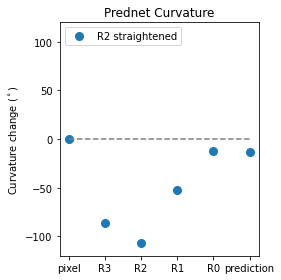

In [17]:
name = 'Prednet'
xlabels = ['pixel', 'R3', 'R2', 'R1', 'R0', 'prediction']
plt.figure(figsize=(4,4))
plt.plot(xlabels, to_plot_change2,'o', markersize=8,label='original')
plt.plot(xlabels, to_plot_change,'o', markersize=8,label='R2 straightened')

plt.title('Prednet Curvature')
plt.legend(loc='upper left')
plt.plot([xlabels[0], xlabels[-1]],[0,0], '--', color='gray')
plt.ylim([-120, 120])
plt.ylabel('Curvature change ($^\circ$)')
plt.tight_layout()
plt.savefig('prednet_R2_straight_4_epochs_larger_new.png', dpi=300)